# Building our models: ALS recommender + Deep Neural Network

### In this notebook we build and test our models: an ALS recommendation system for generating additional hashtags, and a deep neural network for classifying new images to solve the cold start problem. 

### If you wish to reproduce the training steps taken here, you will of course need the dataset. Sadly the 3,000 pictures we used exceed Git's file storage allowances, so you will need to scrape your own images (and of course their associated hashtags). Please refer to scraping.ipynb which features a fully automated pipeline for doing this. 

In [1]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

In [2]:
%load_ext autoreload
%autoreload 2

### Import necessary modules:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from functions import prepare_image, extract_features, extract_features_for_one_image
import os
from tqdm import tqdm
# from PIL import Image
from scipy.spatial.distance import cosine
np.random.seed(0)

### Get a list of all hashtags

In [4]:
json_file_names = os.listdir('metadata')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [5]:
# Build a dataframe of hashtag metadata
hashtag_metadata = []
for hashtag in hashtags: 
    hashtag_metadata.append(pd.read_json(f'metadata/{hashtag}.json'))
hashtag_metadata = reduce(lambda x, y: pd.concat([x, y]), hashtag_metadata)
pd.DataFrame.reset_index(hashtag_metadata, drop=True, inplace=True)
hashtag
hashtag_metadata.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,"[#Wedding, #ido, #ianandwendytietheknot, #wedd...",https://scontent-sea1-1.cdninstagram.com/vp/29...,905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg,https://www.instagram.com/p/B0dcq0FBPQ3/,wedding
2996,"[#wedding, #mariages, #celebrantecuritiba, #ce...",https://scontent-sea1-1.cdninstagram.com/vp/bb...,6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg,https://www.instagram.com/p/BwXbu7MgCTZ/,wedding
2997,"[#weddingring, #wedding, #shoes, #nancy, #sigm...",https://scontent-sea1-1.cdninstagram.com/vp/25...,ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg,https://www.instagram.com/p/B0gwuc2icKv/,wedding
2998,"[#wedding, #standesamtgoetheallee, #retroweddi...",https://scontent-sea1-1.cdninstagram.com/vp/21...,9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg,https://www.instagram.com/p/B0gwufzImAz/,wedding
2999,"[#kinalik, #gelinlik, #bursad, #wedding, #dama...",https://scontent-sea1-1.cdninstagram.com/vp/15...,09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg,https://www.instagram.com/p/B0gwubDhu6M/,wedding


In [6]:
# Remove non-hashtags from hashtag list. 
hashtag_metadata['hashtags'] = hashtag_metadata['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

# Create a flattened list of all hashtags
all_hashtags = [hashtag for hashtags in hashtag_metadata['hashtags'] for hashtag in hashtags]

# Coerce to a set to remove duplicate entries
# Sort to ensure reproducibility of results
all_hashtags = sorted(list(set(all_hashtags)))

# Build lookup for finding hashtag number based on hashtag name
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [7]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,hashtag_id,image_id,rating
47467,3531,2999,1
47468,2321,2999,1
47469,8883,2999,1
47470,15048,2999,1
47471,1313,2999,1


# Creating our Neural Network

In [8]:
img_shape = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

## Data preparation

### Neural networks require very specifically and consistently formatted image data. In the code cell below we build a list of dictionaries each describing one picture: the file name, the (main) hashtag, and of course the image data itself (represented using a TensorFlow "EagerTensor" type). 

In [9]:
pics = []
for i, row in tqdm(hashtag_metadata.iterrows()):
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path, where='local')
        deep_features = extract_features_for_one_image(img, neural_network)
        pics.append({'pic': img, 
                     'hashtag': hashtag, 
                     'name': name,
                     'deep_features': deep_features})
    except Exception as e:
        error_type = type(e).__name__
        if error_type == "NotFoundError":
            # If a file in the list isn't in 
            # storage, skip it and continue
            pass
        else:
            print(e)

3000it [03:39, 13.67it/s]


In [10]:
pics = pd.DataFrame(pics)
pics.head()

,deep_features,hashtag,name,pic
0,"[0.0, 0.0, 0.04703789, 0.80316925, 0.0, 0.0, 0...",fitness,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,"(((tf.Tensor(0.99215686, shape=(), dtype=float..."
1,"[0.28235418, 0.73190904, 0.4228987, 1.8675488,...",fitness,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,"(((tf.Tensor(0.23921573, shape=(), dtype=float..."
2,"[0.0, 0.0, 0.01095562, 0.034995824, 0.0, 0.109...",fitness,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,"(((tf.Tensor(-0.73921573, shape=(), dtype=floa..."
3,"[0.045899887, 0.0, 0.18059976, 0.0, 0.08909201...",fitness,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,"(((tf.Tensor(0.6784314, shape=(), dtype=float3..."
4,"[3.3825152, 0.109845184, 0.0, 0.8362177, 0.857...",fitness,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,"(((tf.Tensor(0.654902, shape=(), dtype=float32..."


In [11]:
# Check the first element of the train set
pic = pics.loc[0] 
type(pic['pic'])

tensorflow.python.framework.ops.EagerTensor

W1005 14:08:24.033562 4527359424 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


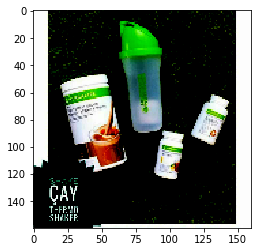

In [12]:
plt.imshow(pic['pic']);

In [13]:
pic['hashtag'], pic['deep_features'].shape, pic['pic'].shape

('fitness', (1280,), TensorShape([160, 160, 3]))

# Building our ALS Model

### In order to appreciably populate a fresh post with new hashtags, we need more than just the singular hashtag that a categorization approach such as our neural network can provide. ALS provides a solution through collaborative filtering: essentially the idea is that if a set of posts all have the same few hashtags in common and a bunch of other unique hashtags, the hashtags that are unique to those posts can probably be applied to all of them. In practice this works uncannily well and is the basis of many modern recommendation systems--remember seeing "People who bought this also bought..."? 

### In addition to supplementing our cold start solution, ALS can add new hashtags to images that already have them in much the same way that it can sell new products to users that have already bought things. So if any image has no hashtags at all or just doesn't have as many as we want it to have yet, we can add more to it either way. 

In [14]:
spark = SparkSession.builder.master('local').getOrCreate()

In [15]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

als.setSeed(0)

hashtag_spark_df = spark.createDataFrame(hashtag_rec_data)
als_model = als.fit(hashtag_spark_df)
# als_model.write().overwrite().save('als')

In [16]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
len(recs)

2261

In [17]:
hashtag_index = list(all_hashtags)

In [18]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [19]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [20]:
recs.index = recs['image_id']

In [21]:
recs = recs.join(hashtag_metadata, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [22]:
recs.loc[0, 'image_local_name']

'ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg'

In [23]:
recs.drop('recommendations', axis=1, inplace=True)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
recs.join(image_factors);

In [24]:
len(hashtag_lookup), type(hashtag_lookup)

(15248, dict)

In [25]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#A,0
#ADN,1
#AFV,2
#AMG,3
#ANGELCORONA,4


In [26]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#A,0
#ADN,1
#AFV,2
#AMG,3
#ANGELCORONA,4


In [27]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']
hashtags_df.index = hashtags_df['id']
hashtags_df.drop('id', axis=1, inplace=True)
hashtags_df.head()

,hashtag
id,
0,#A
1,#ADN
2,#AFV
3,#AMG
4,#ANGELCORONA


In [28]:
img_features = als_model.userFactors.toPandas()
hashtag_features = als_model.itemFactors.toPandas()

In [29]:
pics.index = pics['name']
pics.head()

,deep_features,hashtag,name,pic
name,,,,
ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,"[0.0, 0.0, 0.04703789, 0.80316925, 0.0, 0.0, 0...",fitness,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,"(((tf.Tensor(0.99215686, shape=(), dtype=float..."
7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,"[0.28235418, 0.73190904, 0.4228987, 1.8675488,...",fitness,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,"(((tf.Tensor(0.23921573, shape=(), dtype=float..."
b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,"[0.0, 0.0, 0.01095562, 0.034995824, 0.0, 0.109...",fitness,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,"(((tf.Tensor(-0.73921573, shape=(), dtype=floa..."
f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,"[0.045899887, 0.0, 0.18059976, 0.0, 0.08909201...",fitness,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,"(((tf.Tensor(0.6784314, shape=(), dtype=float3..."
7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,"[3.3825152, 0.109845184, 0.0, 0.8362177, 0.857...",fitness,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,"(((tf.Tensor(0.654902, shape=(), dtype=float32..."


In [30]:
recs.head()

,recommended_hashtags,hashtags,image_local_name,search_hashtag
image_id,,,,
1580,"[#luxury, #cars, #car, #race, #love, #lifestyl...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars
471,"[#beauty, #beautiful, #style, #followme, #smil...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie
1591,"[#cars, #car, #trucks, #street, #a, #mustang, ...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars
463,"[#selfie, #fashion, #style, #ootd, #me, #music...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie
833,"[#wedding, #nature, #art, #photography, #archi...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel


In [31]:
# Add deep features information to recs dataframe
recs_deep = recs.join(pics, on='image_local_name', how='inner')
recs_deep.head()

,recommended_hashtags,hashtags,image_local_name,search_hashtag,deep_features,hashtag,name,pic
image_id,,,,,,,,
1580,"[#luxury, #cars, #car, #race, #love, #lifestyl...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars,"[0.05277507, 0.008059845, 0.37157044, 1.259721...",cars,88039d35-d189-4db3-926e-a120d88a3efc.jpg,"(((tf.Tensor(0.845098, shape=(), dtype=float32..."
471,"[#beauty, #beautiful, #style, #followme, #smil...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie,"[0.8612797, 0.0, 0.0, 0.0, 0.47858256, 0.28118...",selfie,fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,"(((tf.Tensor(0.69411767, shape=(), dtype=float..."
1591,"[#cars, #car, #trucks, #street, #a, #mustang, ...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars,"[0.0, 0.0, 0.0, 2.6671624, 0.11534053, 0.01738...",cars,1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,"(((tf.Tensor(0.92941177, shape=(), dtype=float..."
463,"[#selfie, #fashion, #style, #ootd, #me, #music...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie,"[0.11383952, 0.0, 1.6760653, 0.46152505, 0.062...",selfie,a78d0e30-6afa-436a-a953-633ef3f64325.jpg,"(((tf.Tensor(-0.7254902, shape=(), dtype=float..."
833,"[#wedding, #nature, #art, #photography, #archi...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel,"[0.40182838, 0.0, 0.028864231, 0.0, 0.13101286...",travel,535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,"(((tf.Tensor(0.99215686, shape=(), dtype=float..."


In [32]:
# Only use certain columns
recs_deep_clean = recs_deep[['image_local_name', 'hashtags', 'deep_features']]

img_features.index = img_features['id']
img_features.drop(['id'], axis=1)

# Add image feature into dataframe
recommender_df = recs_deep_clean.join(img_features, how='inner')
recommender_df.head()

,image_local_name,hashtags,deep_features,id,features
1580,88039d35-d189-4db3-926e-a120d88a3efc.jpg,"[#checkeredflag, #atv, #flagmanracing, #dirtbi...","[0.05277507, 0.008059845, 0.37157044, 1.259721...",1580,"[-0.7663350105285645, -0.1312631368637085, -0...."
471,fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,"[#followme, #fashiondaily, #summer, #food, #ma...","[0.8612797, 0.0, 0.0, 0.0, 0.47858256, 0.28118...",471,"[0.2623550593852997, -0.2806769907474518, -1.0..."
1591,1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,"[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...","[0.0, 0.0, 0.0, 2.6671624, 0.11534053, 0.01738...",1591,"[-0.17759329080581665, -0.05472369119524956, 0..."
463,a78d0e30-6afa-436a-a953-633ef3f64325.jpg,"[#followme, #hotguy, #instaboy, #gay, #instaga...","[0.11383952, 0.0, 1.6760653, 0.46152505, 0.062...",463,"[0.19329072535037994, -0.48493003845214844, -0..."
833,535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,"[#arte, #interiordesign, #archilovers, #argent...","[0.40182838, 0.0, 0.028864231, 0.0, 0.13101286...",833,"[0.034018490463495255, 0.5612558722496033, -0...."


In [33]:
# Function that finds k nearest neighbors by cosine similarity
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    """Find image features (user vectors) for similar images."""
    prep_image = prepare_image(image_path, where='local')
    pics = extract_features_for_one_image(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, pics))
    rdf = rdf.sort_values(by='dist')
    # return rdf.head(k)['features']
    return rdf.head(k)

In [34]:
# Test the function on a local image
fnv = find_neighbor_vectors('test_wedding.jpg', 
                k=5, recommender_df=recommender_df)

fnv

,image_local_name,hashtags,deep_features,id,features,dist
279,4098cbe2-7a78-42e2-b91a-56e136309235.jpg,"[#ootd, #cute, #cuteoutfits, #fashionblogger, ...","[0.59663874, 2.8411949, 0.0, 1.0908401, 3.6305...",279,"[-0.4379356801509857, -0.2562393248081207, -0....",0.394075
2968,c001507f-02e6-4fb4-aa49-27a139018cd4.jpg,"[#wedding, #gythio, #greece, #MarriedInMani, #...","[0.1577508, 1.9940056, 0.6179217, 0.0, 3.20988...",2968,"[0.06409487128257751, 0.17010177671909332, 0.0...",0.416801
2827,7a8c4976-7026-4fc1-acb8-e142e68bc954.jpg,"[#wedding, #instacool, #likelike, #like, #like...","[1.4847815, 0.20136786, 0.0, 0.0, 3.6014907, 0...",2827,"[-0.08119690418243408, -0.37123215198516846, -...",0.417307
763,edf9daee-f603-46b5-bf4a-ae9974bb89ad.jpg,"[#wanderlust, #toddlers, #woods, #forest, #nc,...","[0.74691504, 1.2644943, 0.0, 0.23730093, 2.684...",763,"[-0.04946551471948624, 0.4574536383152008, -0....",0.420474
223,d5c1c965-47e1-492e-842b-118ea059ba32.jpg,"[#instagram, #nehakakkar, #trending, #beauty, ...","[0.0, 0.0, 0.0, 0.95545685, 2.4236383, 0.06909...",223,"[-0.2672896981239319, -0.3606613576412201, -0....",0.421033


### Next step to do: after identifying 5 nearest neighbors, look at ALS's image features (user features), get the average for 5. Then compute dot product with every hashtag features vector (item features). Take hashtags woth the highest reasult as recommendations.

In [35]:
# Check length of the user features
len(fnv.iloc[3, 4])

10

## Find the average of the 5 user features found based on cosine similarity.

In [36]:
# Extract features from dataframe
features = []
for item in fnv.features.values:
    features.append(item)

In [37]:
avg_features = np.mean(np.asarray(features), axis=0)

## Find the dot product with each hashtag features

In [38]:
# Take a look at the hashtag features extracted from ALS model
hashtag_features.head()

,id,features
0,0,"[0.013514621183276176, 0.0060710902325809, -0...."
1,10,"[-0.022118818014860153, 0.022967413067817688, ..."
2,20,"[-0.023419266566634178, -0.03771517798304558, ..."
3,30,"[-0.06050879508256912, 0.0056569818407297134, ..."
4,40,"[0.005097324959933758, -0.0011513691861182451,..."


In [39]:
# Add new column to the hashtag features which will be the dot product with the average image(user) features
hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))

# Get 10 ids with the highest dot product
df_ten_highest = hashtag_features.sort_values(by='dot_product', ascending=False).head(10)
rec_hashtag_ids = df_ten_highest.id.values

## Find hashtags that correspond to the ids

In [40]:
hashtags_df.head()

,hashtag
id,
0,#A
1,#ADN
2,#AFV
3,#AMG
4,#ANGELCORONA


In [41]:
for i in rec_hashtag_ids:
    print(hashtags_df.loc[hashtags_df.index==i]['hashtag'])

id
8673    #love
Name: hashtag, dtype: object
id
5204    #fashion
Name: hashtag, dtype: object
id
7441    #instagood
Name: hashtag, dtype: object
id
12910    #summer
Name: hashtag, dtype: object
id
10772    #photography
Name: hashtag, dtype: object
id
13649    #travel
Name: hashtag, dtype: object
id
6655    #happy
Name: hashtag, dtype: object
id
1639    #art
Name: hashtag, dtype: object
id
8442    #like
Name: hashtag, dtype: object
id
10838    #picoftheday
Name: hashtag, dtype: object
